In [20]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import spacy
import nltk
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

import re

In [38]:
df = pd.read_csv("../data/data_email.csv")
df.head()

,email,label
0,\nSave up to 70% on Life Insurance.\nWhy Spend...,spam
1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,spam
2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,spam
3,##############################################...,spam
4,I thought you might like these:\n1) Slim Down ...,spam


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11797 entries, 0 to 11796
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   email   11796 non-null  object
 1   label   11797 non-null  object
dtypes: object(2)
memory usage: 184.5+ KB


In [40]:
df["email"] = df["email"].astype(str)
df["label"] = df["label"].astype(str)

## Data Visualization

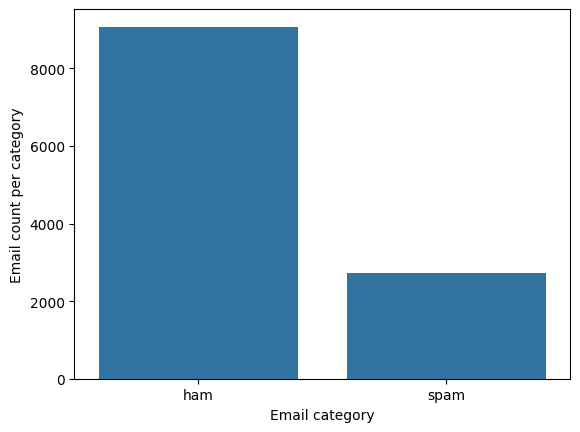

In [19]:
sns.barplot(df["label"].value_counts())
plt.ylabel("Email count per category")
plt.xlabel("Email category")
plt.show()

## Data cleaning and preprocessing

In [46]:
def clean_text_with_regex(text):
    regex = r'[^A-Za-z\s]'
    return " ".join(re.sub(regex, '', text).replace("\n", "").rsplit())

In [47]:
df["email"].apply(clean_text_with_regex)

0        Save up to on Life InsuranceWhy Spend More Tha...
1        Fight The Risk of Cancerhttpwwwadclickwspcfmos...
2        Fight The Risk of Cancerhttpwwwadclickwspcfmos...
3        Adult Club Offers FREE Membership INSTANT ACCE...
4        I thought you might like these Slim Down Guara...
                               ...                        
11792    Were pleased to inform you that your refund ha...
11793    Get rich quick Invest in our revolutionary new...
11794    Your free trial period is ending soon Upgrade ...
11795    Your order is on its way Track your shipment f...
11796    Limitedtime offer Get off on all purchases tod...
Name: email, Length: 11797, dtype: object